In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Plan:
* Dataset
    * Missing data detection
    * Interpolation
    * Rescale 10 minutes interval to 60 minutes
    * Inspect the data and clearn
    * Feature engineering: wind; Time
    * Normalize the data
    * Splitting
* Data windowing
    * Indexes and offsets
    * Split
    * Plot
    * Metrics
    * Create tf.data.Datasets
* Single step models. Single output feature.
    * Baseline
    * Linear model
    * Dense
    * Multi-step dense
    * Convolution neural network
    * Recurrent neural network (LSTM)
    * Performance competition
* Single step models. Multi-output features.
    * Baseline
    * Dense
    * RNN (LSTM)
    * Advanced: Residual connections
    * Performance competition
* Multiple time step predictions
    * Baselines
    * Single-shot models (Entire sequence prediction in a single step)
        * Linear model
        * Dense
        * CNN
        * RNN (LSTM)
    * Advanced: Autoregressive model with RNN LSTMCell wrapper (AR LSTM)
        * AR LSTM
    * Performance competition

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head(5)

13568290/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Dataset
## Missing data detection

The Proposed solution is taking each 4ts records

Pluses:
* fast results

Risks:
* assumes that there are no missing values (looking ahead: in reality, gaps happen when data comes from a broker)

Reduce:
* How can you quickly check for missing values? - Count! We know the first and last date, and clock (ticker) value

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [ ]:
df = pd.read_csv(csv_path)
tacts_amount = 6
datetime_first = pd.Timestamp(df['Date Time'][0])
datetime_last = pd.Timestamp(df['Date Time'].iloc[-1])
tacts = pd.to_timedelta(datetime_last - datetime_first).total_seconds() / (10 * 60)

print('First date:', datetime_first)
print('Last date:', datetime_last)
print('Expected:', tacts)
print('Shape:', df.shape[0])
print('Diff between Expected and shaped', tacts - df.shape[0])
print('Diff in hours', (tacts - df.shape[0]) / 6)

First date: 2009-01-01 00:10:00
Last date: 2017-01-01 00:00:00
Expected: 420767.0
Shape: 420551
Diff between Expected and shaped 216.0
Diff in hours 36.0


In [ ]:
%%time
df1 = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df1 = df1[5::6]
date_time = pd.to_datetime(df1.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
print(df1.shape)

(70091, 14)
CPU times: user 778 ms, sys: 73.4 ms, total: 851 ms
Wall time: 873 ms


In [ ]:
df1.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
date_time[:24]

5     2009-01-01 01:00:00
11    2009-01-01 02:00:00
17    2009-01-01 03:00:00
23    2009-01-01 04:00:00
29    2009-01-01 05:00:00
35    2009-01-01 06:00:00
41    2009-01-01 07:00:00
47    2009-01-01 08:00:00
53    2009-01-01 09:00:00
59    2009-01-01 10:00:00
65    2009-01-01 11:00:00
71    2009-01-01 12:00:00
77    2009-01-01 13:00:00
83    2009-01-01 14:00:00
89    2009-01-01 15:00:00
95    2009-01-01 16:00:00
101   2009-01-01 17:00:00
107   2009-01-01 18:00:00
113   2009-01-01 19:00:00
119   2009-01-01 20:00:00
125   2009-01-01 21:00:00
131   2009-01-01 22:00:00
137   2009-01-01 23:00:00
143   2009-01-02 00:00:00
Name: Date Time, dtype: datetime64[ns]

In [ ]:
%%time
df1 = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df1 = df1[5::6]
df1['Date Time'] = pd.to_datetime(df1['Date Time'], format='%d.%m.%Y %H:%M:%S')
df1 = df1.set_index('Date Time')
print(df.shape)

(420551, 15)
CPU times: user 679 ms, sys: 65.7 ms, total: 744 ms
Wall time: 751 ms


**Note:** The data has missing


## Interpolate missing values and rescale to 1h

In [ ]:
%%time
df2 = pd.read_csv(csv_path)
print('Shape before intorpolation:', df2.shape)
df2['Date Time'] = pd.to_datetime(df2['Date Time'], format='%d.%m.%Y %H:%M:%S')
# df2 = df2.set_index('Date Time').resample('60min').mean()
df2 = df2.set_index('Date Time').resample('60min').first()
print('Shape after intorpolation:', df2.shape)

Shape before intorpolation: (420551, 15)
Shape after intorpolation: (70129, 14)
CPU times: user 1.71 s, sys: 132 ms, total: 1.85 s
Wall time: 1.84 s


In [ ]:
print('Shape before interpolation:', df2.shape)
df2 = df2.iloc[1: -1, :]
print('Shape after interpolation:', df2.shape)

Shape before interpolation: (70129, 14)
Shape after interpolation: (70127, 14)


In [ ]:
idx1 = df2.index
idx2 = df1.index
idx1.difference(idx2)

# missing_indexes = df2.index[~df2.index.isin(df1.index)]

# missing_indexes = list(set(df2.index.to_list()) - set(df1.index.to_list()))
# len(missing_indexes)

DatetimeIndex(['2009-10-08 10:00:00', '2009-10-08 11:00:00',
               '2009-10-08 12:00:00', '2009-10-08 13:00:00',
               '2009-10-08 14:00:00', '2009-10-08 15:00:00',
               '2009-10-08 16:00:00', '2009-10-08 17:00:00',
               '2009-10-08 18:00:00', '2009-10-08 19:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date Time', length=41966, freq=None)

In [ ]:
df1

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7


In [ ]:
print('Shape fast approach:', df1.shape)
print('Shape interpolated approach:', df2.shape)

Shape fast approach: (70091, 14)
Shape interpolated approach: (70127, 14)


In [ ]:
df1.head(25)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


In [ ]:
df2.head(25)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


In [ ]:
df1.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-12-31 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
2016-12-31 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7
2016-12-31 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6


In [ ]:
df2.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-12-31 19:00:00,1002.26,-1.03,271.96,-5.64,70.70,5.67,4.01,1.66,2.49,4.00,1281.06,0.82,1.26,227.10
2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
2016-12-31 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70


In [ ]:
df.tail(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420541,31.12.2016 22:30:00,1000.44,-4.08,269.05,-7.89,74.60,4.51,3.37,1.15,2.10,3.37,1293.55,1.27,2.48,192.1
420542,31.12.2016 22:40:00,1000.45,-4.45,268.68,-7.15,81.30,4.39,3.57,0.82,2.22,3.57,1295.24,0.80,1.44,183.8
420543,31.12.2016 22:50:00,1000.32,-4.09,269.05,-7.23,78.60,4.51,3.54,0.96,2.21,3.54,1293.37,1.25,1.60,199.2
420544,31.12.2016 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.7
420545,31.12.2016 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


There are some gaps in the data. We can see this by the calculation and tails.
Better to use interpolated approach.

In [ ]:
%%time
df1 = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df1 = df1[5::6]
date_time = pd.to_datetime(df1.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
date_time

CPU times: user 666 ms, sys: 56.2 ms, total: 722 ms
Wall time: 723 ms


5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [ ]:
%%time
df = pd.read_csv(csv_path)
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df = df.set_index('Date Time').resample('60min').first()
# date_time = df2.index
# df2 = df2.reset_index(drop=True)

CPU times: user 1.75 s, sys: 90.9 ms, total: 1.84 s
Wall time: 1.82 s


In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0


In [ ]:
# date_time = df.index
# df2 = df.reset_index(drop=True)

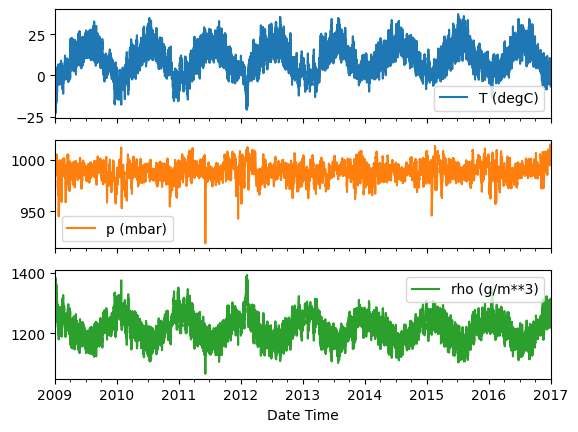

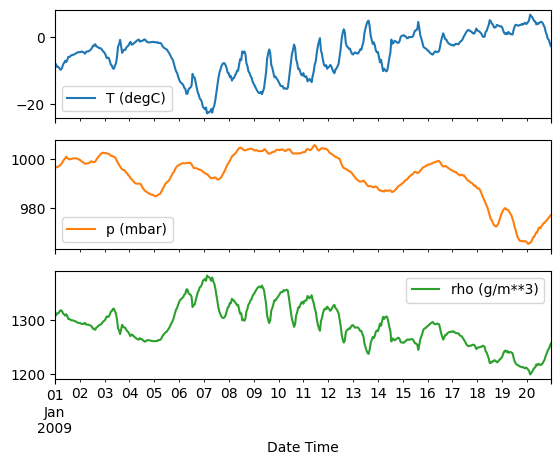

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df.index[:480]
_ = plot_features.plot(subplots=True)

## Inspect data and clean

In [ ]:
df.isna().sum()

p (mbar)           88
T (degC)           88
Tpot (K)           88
Tdew (degC)        88
rh (%)             88
VPmax (mbar)       88
VPact (mbar)       88
VPdef (mbar)       88
sh (g/kg)          88
H2OC (mmol/mol)    88
rho (g/m**3)       88
wv (m/s)           88
max. wv (m/s)      88
wd (deg)           88
dtype: int64

In [ ]:
df[df['p (mbar)'].isna()]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2014-09-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-28 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-28 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-28 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_filled = df.fillna(df.mean())
df_filled.isna().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [ ]:
df_filled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70129.0,989.214413,8.355569,918.50,984.21,989.570000,994.72,1015.29
T (degC),70129.0,9.441751,8.415149,-22.76,3.36,9.420000,15.45,37.28
Tpot (K),70129.0,283.484199,8.496214,250.85,277.44,283.480000,289.50,311.21
Tdew (degC),70129.0,4.953206,6.727452,-24.80,0.24,5.200000,10.06,22.94
rh (%),70129.0,76.029093,16.447086,13.06,65.32,79.200000,89.40,100.00
VPmax (mbar),70129.0,13.567769,7.729179,0.97,7.78,11.820000,17.58,63.77
VPact (mbar),70129.0,9.532245,4.181638,0.81,6.22,8.870000,12.35,28.04
VPdef (mbar),70129.0,4.035438,4.887248,0.00,0.87,2.180000,5.28,46.01
sh (g/kg),70129.0,6.021458,2.654564,0.51,3.92,5.600000,7.80,17.94
H2OC (mmol/mol),70129.0,9.638694,4.232857,0.81,6.29,8.970000,12.48,28.53


In [ ]:
df_filled[df_filled['wv (m/s)'] == -9999.00].head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.0,-9999.0,359.8
2015-07-13 11:00:00,990.16,18.71,292.70,12.48,67.07,21.61,14.50,7.12,9.16,14.64,1175.26,-9999.0,-9999.0,359.8
2015-07-13 12:00:00,990.15,18.75,292.74,12.27,65.97,21.67,14.29,7.37,9.03,14.44,1175.18,-9999.0,-9999.0,359.8


In [ ]:
df_filled[df_filled['wv (m/s)'] == -9999.0] = 0.0
df_filled[df_filled['max. wv (m/s)'] == -9999.0] = 0.0

df_filled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70129.0,989.157931,11.208349,0.00,984.21,989.560000,994.72,1015.29
T (degC),70129.0,9.440719,8.415195,-22.76,3.36,9.420000,15.45,37.28
Tpot (K),70129.0,283.467539,8.761560,0.00,277.44,283.480000,289.50,311.21
Tdew (degC),70129.0,4.952487,6.727308,-24.80,0.24,5.200000,10.06,22.94
rh (%),70129.0,76.025078,16.457017,0.00,65.31,79.200000,89.40,100.00
VPmax (mbar),70129.0,13.566581,7.729661,0.00,7.77,11.820000,17.58,63.77
VPact (mbar),70129.0,9.531411,4.182081,0.00,6.21,8.870000,12.35,28.04
VPdef (mbar),70129.0,4.035084,4.887308,0.00,0.87,2.180000,5.28,46.01
sh (g/kg),70129.0,6.020932,2.654842,0.00,3.92,5.600000,7.80,17.94
H2OC (mmol/mol),70129.0,9.637851,4.233306,0.00,6.29,8.970000,12.48,28.53


In [ ]:
df_filled[df_filled['p (mbar)'] == 0].head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-13 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-13 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-13 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(df_filled.shape[0])
df_filled = df_filled[df_filled['p (mbar)'] != 0]
print(df_filled.shape[0])
df_filled.describe().transpose()

70129
70125


,count,mean,std,min,25%,50%,75%,max
p (mbar),70125.0,989.214353,8.355804,918.50,984.21,989.570000,994.72,1015.29
T (degC),70125.0,9.441257,8.415132,-22.76,3.36,9.420000,15.45,37.28
Tpot (K),70125.0,283.483709,8.496206,250.85,277.44,283.480000,289.50,311.21
Tdew (degC),70125.0,4.952769,6.727396,-24.80,0.24,5.200000,10.06,22.94
rh (%),70125.0,76.029414,16.447467,13.06,65.32,79.200000,89.40,100.00
VPmax (mbar),70125.0,13.567355,7.729202,0.97,7.78,11.820000,17.58,63.77
VPact (mbar),70125.0,9.531955,4.181580,0.81,6.22,8.870000,12.35,28.04
VPdef (mbar),70125.0,4.035314,4.887352,0.00,0.87,2.180000,5.28,46.01
sh (g/kg),70125.0,6.021275,2.654529,0.51,3.92,5.600000,7.80,17.94
H2OC (mmol/mol),70125.0,9.638401,4.232800,0.81,6.29,8.970000,12.48,28.53


In [ ]:
print(df_filled[df_filled['VPdef (mbar)'] == 0].shape[0])
df_filled[df_filled['VPdef (mbar)'] == 0].head()

287


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-27 23:00:00,990.80,-1.63,272.25,-1.63,100.0,5.42,5.42,0.0,3.41,5.47,1268.52,1.68,2.38,40.01
2009-01-28 00:00:00,990.97,-1.68,272.19,-1.68,100.0,5.40,5.40,0.0,3.40,5.45,1268.98,0.00,0.00,0.00
2009-01-28 01:00:00,990.87,-1.63,272.24,-1.63,100.0,5.42,5.42,0.0,3.41,5.47,1268.63,0.00,0.00,0.00
2009-01-28 02:00:00,990.85,-1.69,272.18,-1.69,100.0,5.39,5.39,0.0,3.39,5.44,1268.89,0.00,0.00,0.00
2009-01-28 03:00:00,991.29,-1.69,272.15,-1.69,100.0,5.39,5.39,0.0,3.39,5.44,1269.46,0.00,0.00,0.00


## Feature engineering

### wind

Text(0, 0.5, 'Wind Velocity [m/s]')

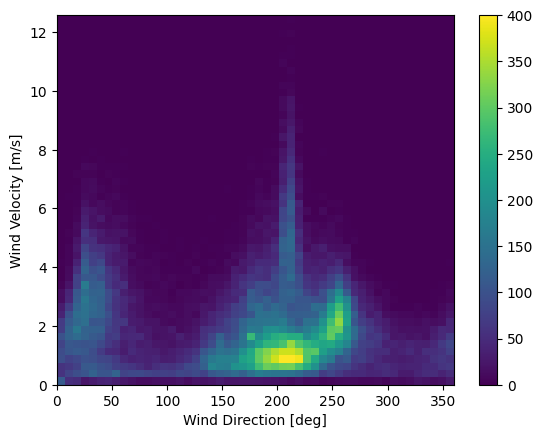

In [ ]:
plt.hist2d(df_filled['wd (deg)'], df_filled['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [ ]:
# But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

wv = df_filled.pop('wv (m/s)')
max_wv = df_filled.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df_filled.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df_filled['Wx'] = wv*np.cos(wd_rad)
df_filled['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df_filled['max Wx'] = max_wv*np.cos(wd_rad)
df_filled['max Wy'] = max_wv*np.sin(wd_rad)

In [ ]:
df['max. wv (m/s)'].describe()

count    70041.000000
mean         2.961363
std         75.624368
min      -9999.000000
25%          1.760000
50%          2.960000
75%          4.730000
max         20.330000
Name: max. wv (m/s), dtype: float64

In [ ]:
df_filled['max Wx'].describe()

count    70125.000000
mean        -1.019501
std          3.087052
min        -18.146270
25%         -2.471661
50%         -1.120977
75%          0.625470
max         11.577076
Name: max Wx, dtype: float64

In [ ]:
df_filled['max Wx']

Date Time
2009-01-01 00:00:00   -1.549439
2009-01-01 01:00:00   -0.614587
2009-01-01 02:00:00   -0.619848
2009-01-01 03:00:00   -0.614344
2009-01-01 04:00:00   -0.190000
                         ...   
2016-12-31 20:00:00   -1.206696
2016-12-31 21:00:00   -1.312776
2016-12-31 22:00:00    0.712728
2016-12-31 23:00:00   -0.939857
2017-01-01 00:00:00   -1.952837
Name: max Wx, Length: 70125, dtype: float64

(-11.041286574252789, 8.17361280768906, -7.227854793543882, 7.4305749172788875)

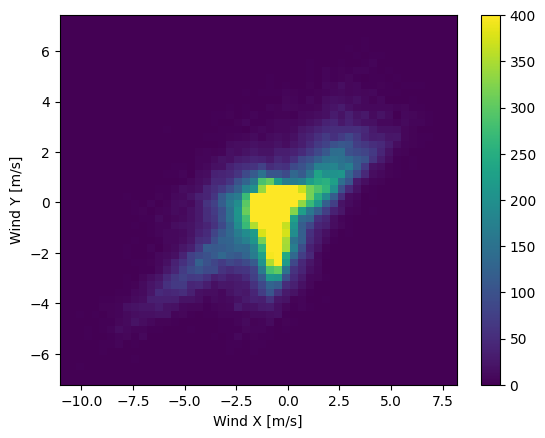

In [ ]:
plt.hist2d(df_filled['Wx'], df_filled['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [ ]:
df_filled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70125.0,989.214353,8.355804,918.500000,984.210000,989.570000,994.720000,1015.290000
T (degC),70125.0,9.441257,8.415132,-22.760000,3.360000,9.420000,15.450000,37.280000
Tpot (K),70125.0,283.483709,8.496206,250.850000,277.440000,283.480000,289.500000,311.210000
Tdew (degC),70125.0,4.952769,6.727396,-24.800000,0.240000,5.200000,10.060000,22.940000
rh (%),70125.0,76.029414,16.447467,13.060000,65.320000,79.200000,89.400000,100.000000
VPmax (mbar),70125.0,13.567355,7.729202,0.970000,7.780000,11.820000,17.580000,63.770000
VPact (mbar),70125.0,9.531955,4.181580,0.810000,6.220000,8.870000,12.350000,28.040000
VPdef (mbar),70125.0,4.035314,4.887352,0.000000,0.870000,2.180000,5.280000,46.010000
sh (g/kg),70125.0,6.021275,2.654529,0.510000,3.920000,5.600000,7.800000,17.940000
H2OC (mmol/mol),70125.0,9.638401,4.232800,0.810000,6.290000,8.970000,12.480000,28.530000


### Time analysing

In [ ]:
timestamp_s = df_filled.index.map(pd.Timestamp.timestamp)
timestamp_s

Float64Index([1230768000.0, 1230771600.0, 1230775200.0, 1230778800.0,
              1230782400.0, 1230786000.0, 1230789600.0, 1230793200.0,
              1230796800.0, 1230800400.0,
              ...
              1483196400.0, 1483200000.0, 1483203600.0, 1483207200.0,
              1483210800.0, 1483214400.0, 1483218000.0, 1483221600.0,
              1483225200.0, 1483228800.0],
             dtype='float64', name='Date Time', length=70125)

you can determine which frequencies are important by extracting features with Fast Fourier Transform. To check the assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

shape: 70125
n_samples_h: 70125
years_per_dataset: 7.999605204510634
f_per_year: [0.         0.12500617 0.25001234]


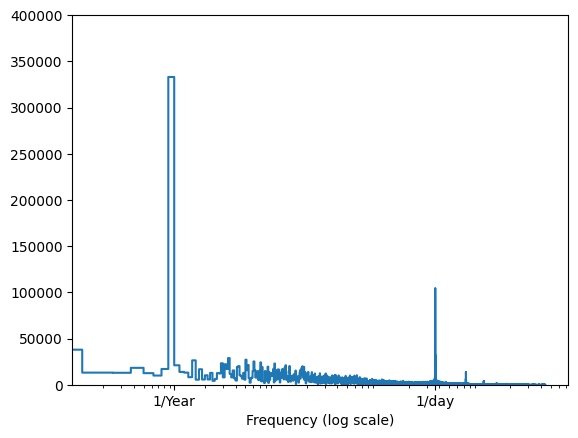

In [ ]:
fft = tf.signal.rfft(df_filled['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_filled['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
print('shape:', df_filled.shape[0])
print('n_samples_h:', n_samples_h)
print('years_per_dataset:', years_per_dataset)
print('f_per_year:', f_per_year[:3])

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

"Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:"

In [ ]:
day = 24*60*60
year = (365.2425)*day

df_filled['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_filled['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_filled['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_filled['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

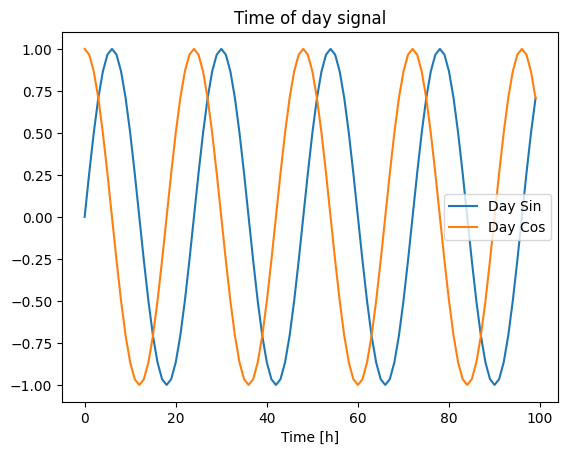

In [ ]:
plt.plot(np.array(df_filled['Day sin'])[:100], label='Day Sin')
plt.plot(np.array(df_filled['Day cos'])[:100], label='Day Cos')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()

## Normalize the data

Common practice is making normalisation before splitting

In [ ]:
mean = df_filled.mean()
std = df_filled.std()

df_norm = (df_filled - mean) / std
df_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70125.0,8.041165e-16,1.0,-8.462903,-0.598907,0.042563,0.658901,3.120663
T (degC),70125.0,8.754494e-17,1.0,-3.826589,-0.722657,-0.002526,0.714040,3.308176
Tpot (K),70125.0,6.517235e-15,1.0,-3.840974,-0.711342,-0.000436,0.708115,3.263373
Tdew (degC),70125.0,-6.809051e-17,1.0,-4.422628,-0.700534,0.036750,0.759169,2.673729
rh (%),70125.0,5.812012e-16,1.0,-3.828518,-0.651129,0.192770,0.812927,1.457403
VPmax (mbar),70125.0,-3.663918e-16,1.0,-1.629839,-0.748765,-0.226072,0.519154,6.495191
VPact (mbar),70125.0,-4.442095e-16,1.0,-2.085803,-0.792034,-0.158302,0.673919,4.426089
VPdef (mbar),70125.0,2.756045e-17,1.0,-0.825665,-0.647654,-0.379615,0.254675,8.588431
sh (g/kg),70125.0,1.945443e-16,1.0,-2.076178,-0.791581,-0.158700,0.670072,4.489959
H2OC (mmol/mol),70125.0,-2.431804e-16,1.0,-2.085712,-0.791061,-0.157910,0.671328,4.463144


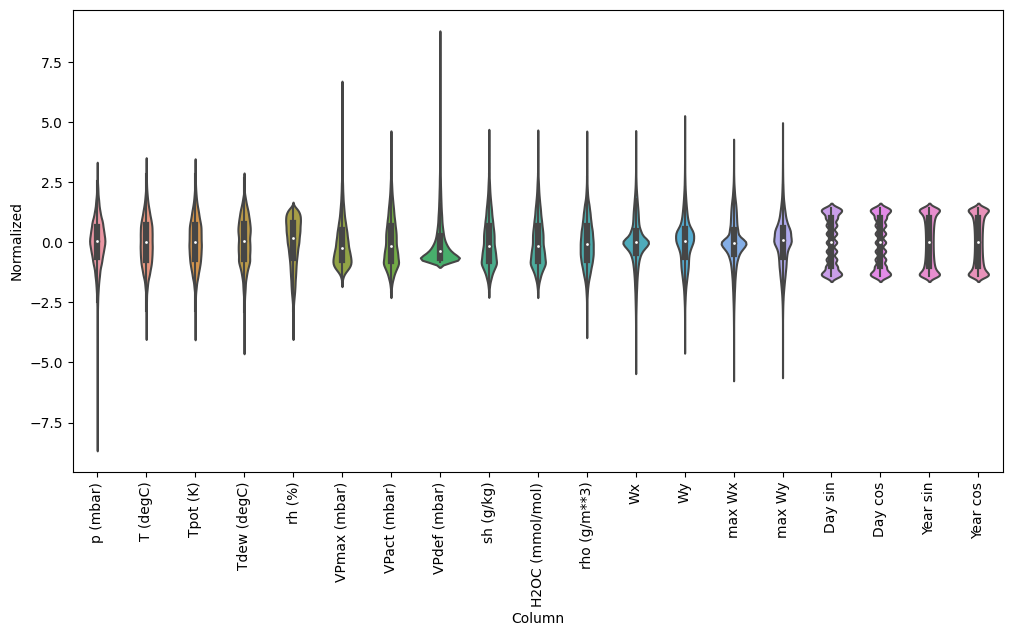

In [ ]:
df_std = (df_filled - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_filled.keys(), rotation=90)

## Split the data

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [ ]:
# 70/20/10
n = df_filled.shape[0]
train_df = df_filled[0:int(n*0.7)]
val_df = df_filled[int(n*0.7):int(n*0.9)]
test_df = df_filled[int(n*0.9):]
print(df_filled.shape[0], train_df.shape[0] + val_df.shape[0] + test_df.shape[0])
print('train_df shape:', train_df.shape[0])
print('val_df shape:', val_df.shape[0])
print('test_df shape:', test_df.shape[0])

70125 70125
train_df shape: 49087
val_df shape: 14025
test_df shape: 7013


In [ ]:
num_features = df_filled.shape[1]
num_features

19

# Data Windowing

In the context of time series forecasting, input windows are a common approach to training predictive models. An input window is a fixed-size sequence of past observations from the time series that is used to predict the next value(s) in the series.

The main features of an input window are:

1. Size: The number of past observations included in the window. The size of the input window can significantly affect the performance of the model, as a larger window may capture more complex patterns but may also lead to overfitting.

2. Lag: The time interval between the last observation in the input window and the time point being predicted. The lag can also affect the model performance, as a smaller lag may capture more recent trends but may be less able to capture longer-term patterns.

3. Overlapping: Whether or not the input windows overlap with each other. Overlapping windows can provide more training data for the model, but may also lead to higher dependence between the training examples.

4. Normalization: Whether or not the input window is normalized before being fed into the model. Normalization can help to stabilize the input data and improve the model's performance.

5. Target variable: Whether the input window includes the target variable being predicted or not. Including the target variable in the input window can help the model to capture complex dependencies and improve its accuracy.

Overall, the choice of input window features depends on the specific time series and the goals of the forecasting task, and may require experimentation to find the optimal configuration

Data windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:
* The width (number of time steps) of the input and label windows.
* The time offset between them.
* Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:
* Single-output, and multi-output predictions.
* Single-time-step and multi-time-step predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

Here are examples of single-output and multi-output predictions in time series predictions:

1. **Single-Output Prediction**:
    <br />
    In this case, we have a single target variable that we want to predict based on the historical time series data.
    *Example*:
    Let's say we have daily temperature data for a city for the past few years, and we want to predict the temperature for the next day. We have a single target variable (next-day temperature) that we want to predict based on the historical temperature data.

    | Date       | Temperature |
    |------------|------|
    | 2019-01-01 | 	25  |
    | 2019-01-02 | 	23  |
    | 2019-01-03 | 	20  |
    |  ...       | 	... |

    <br />
    In this case, the output of our prediction model will be a single value, which is the predicted temperature for the next day.

    <br />
2. **Multi-Output Prediction**:
   <br />
   In this case, we have multiple target variables that we want to predict simultaneously based on the historical time series data.
    *Example*:
    Let's say we have a dataset with daily stock prices for a company for the past few years, and we want to predict the stock prices for the next day, next week, and next month. We have multiple target variables (next-day price, next-week price, next-month price) that we want to predict based on the historical price data.

    | Date       | Price |
    |------------|-------|
    | 2019-01-01 | 	100  |
    | 2019-01-02 | 	105  |
    | 2019-01-03 | 	102  |
    |  ...       | 	...  |
    <br />
    In this case, the output of our prediction model will be a set of multiple values, representing the predicted prices for the next day, next week, and next month.

In both cases, the goal is to train a predictive model that can learn patterns and relationships from the historical time series data and make accurate predictions for the future. The choice between single-output and multi-output predictions depends on the specific problem and the number of target variables you want to predict.

Here are examples of single-time-step and multi-time-step predictions in time series predictions:

1. **Single-Time-Step Prediction**:
    In this case, we aim to predict the value of the time series at the next time step based on the previous time steps.

    Example:
    Let's say we have hourly electricity consumption data for a building, and we want to predict the electricity consumption for the next hour. We have a single target variable (next-hour consumption) that we want to predict based on the historical consumption data.

    | Timestamp           | Consumption |
    |---------------------|-------------|
    | 2022-01-01 00:00:00 | 100         |
    | 2022-01-01 01:00:00 | 110         |
    | 2022-01-01 02:00:00 | 105         |
    | ...                 | ...         |
    <br/>
    In this case, the output of our prediction model will be a single value, which is the predicted consumption for the next hour.
    <br/>
2. **Multi-Time-Step Prediction**:
    In this case, we aim to predict multiple future time steps of the time series based on the previous time steps.

    Example:
    Let's say we have daily stock price data for a company, and we want to predict the stock prices for the next 5 days. We have multiple target variables (next-day price, next-day+1 price, ..., next-day+4 price) that we want to predict based on the historical price data.

    | Date       | Price |
    |------------|-------|
    | 2022-01-01 | 100   |
    | 2022-01-02 | 110   |
    | 2022-01-03 | 105   |
    | ...        | ...   |
    <br/>
    In this case, the output of our prediction model will be a sequence of multiple values, representing the predicted prices for the next 5 days.
    <br/>
In both cases, the goal is to train a predictive model that can learn patterns and relationships from the historical time series data and make accurate predictions for future time steps. The choice between single-time-step and multi-time-step predictions depends on the specific problem and the number of future time steps you want to predict.

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

**1 Indexes and offsets**
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}',
            f'Label columns indices: {self.label_columns_indices}',
            f'Window size: {self.input_width}',
            f'Shift: {self.shift}',
            f'Total window size: {self.total_window_size}',
        ])

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

![One prediction 24 hours into the future.](images/raw_window_24h.png)

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 24
Shift: 24
Total window size: 48

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

![One prediction one hour into the future.](images/raw_window_1h.png)

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 6
Shift: 1
Total window size: 7

## Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

Typically, **data in TensorFlow is packed into arrays** where:
 * The outermost (0) index is across examples (the **"batch" dimension**).
 * The middle indices (1) are the **"time" or "space" (width, height) dimension(s)**.
 * The innermost indices (2) are the **features**.

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')
print('')
print(f'Example window len: {example_window.shape[0]}')
print(f'Length of the total window size: {w2.total_window_size}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)

Example window len: 3
Length of the total window size: 7


The code above took a batch of three 7-time step windows with 19 features at each time step.

It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label.

The label only has one feature because the WindowGenerator was initialized with label_columns=['T (degC)'].

Initially, this tutorial will build models that predict single output labels.

## Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
print('example_inputs:')
print(example_inputs[:1])
print('')
print('example_labels:')
print(example_labels[:1])
w2.example = example_inputs, example_labels
print('')
print('w2 example:')
print(w2.example[:1])

example_inputs:
tf.Tensor(
[[[ 9.96520000e+02 -8.02000000e+00  2.65400000e+02 -8.90000000e+00
    9.33000000e+01  3.33000000e+00  3.11000000e+00  2.20000000e-01
    1.94000000e+00  3.12000000e+00  1.30775000e+03 -9.11955435e-01
    4.78787307e-01 -1.54943885e+00  8.13473580e-01 -1.77661074e-12
    1.00000000e+00  9.33237110e-03  9.99956452e-01]
  [ 9.96500000e+02 -8.05000000e+00  2.65380000e+02 -8.78000000e+00
    9.44000000e+01  3.33000000e+00  3.14000000e+00  1.90000000e-01
    1.96000000e+00  3.15000000e+00  1.30786000e+03 -2.04862254e-01
   -4.61677029e-02 -6.14586763e-01 -1.38503109e-01  2.58819045e-01
    9.65925826e-01  1.00491198e-02  9.99949506e-01]
  [ 9.96620000e+02 -8.88000000e+00  2.64540000e+02 -9.77000000e+00
    9.32000000e+01  3.12000000e+00  2.90000000e+00  2.10000000e-01
    1.81000000e+00  2.91000000e+00  1.31225000e+03 -2.45971259e-01
   -4.47005538e-02 -6.19847574e-01 -1.12645396e-01  5.00000000e-01
    8.66025404e-01  1.07658633e-02  9.99942046e-01]
  [ 9.9684000

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3, title=None):

    inputs, labels = self.example
    fig = plt.figure(figsize=(12, 8))
    if title is not None:
      fig.suptitle(title)

    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))


    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

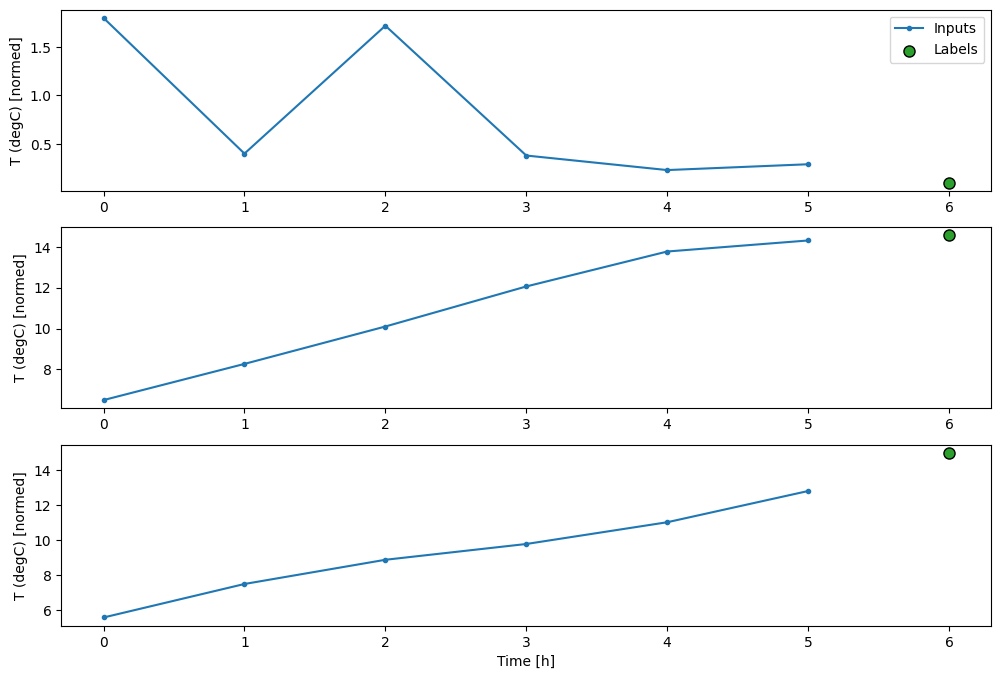

In [ ]:
# by default the example window w2 configuration only has labels for the T (degC) column.
w2.plot()

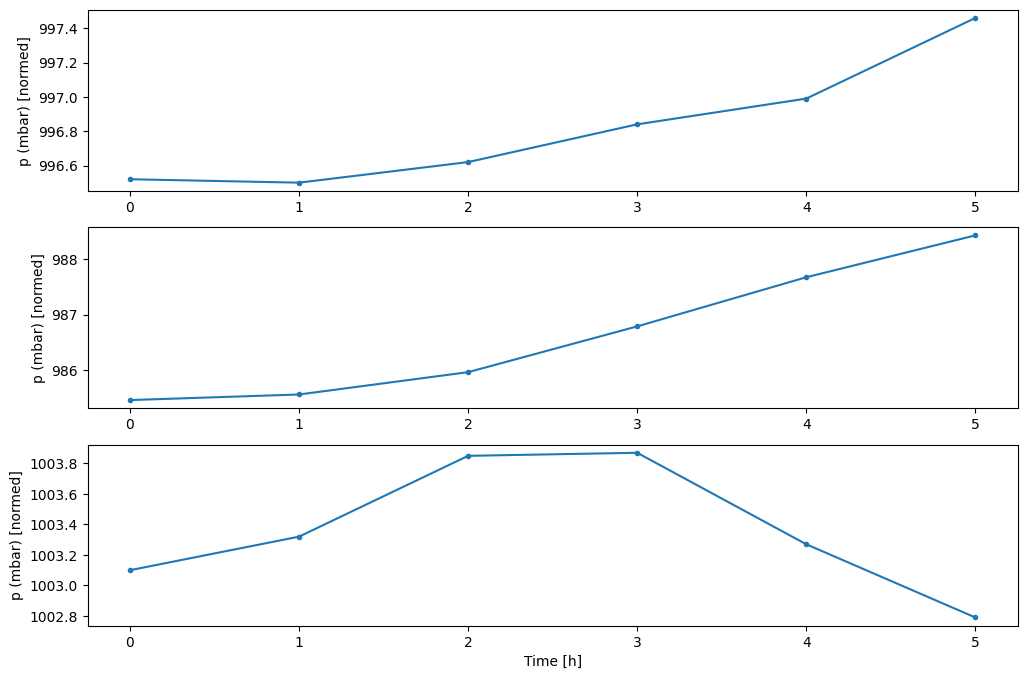

In [ ]:
# by default the example window w2 configuration only has labels for the T (degC) column.
w2.plot(plot_col='p (mbar)')

## Metric

In [ ]:
def cce(self, model=None):
    result = 0
    inputs, labels = self.example

    if model is not None:
        cce = tf.keras.losses.CategoricalCrossentropy()
        predicted = model(inputs)
        result = cce(labels, predicted).numpy()

    #print ('CCE:', result)
    return result

WindowGenerator.cce = cce

In [ ]:
w2.cce()

0

In [ ]:
def accuracy(self, model=None):
    result = 0
    inputs, labels = self.example


    if model is not None:
        m = tf.keras.metrics.Accuracy()
        predict = model(inputs)
        m.update_state(labels, predict, sample_weight=None)
        result = m.result().numpy()

    return result

WindowGenerator.accuracy = accuracy

In [ ]:
w2.accuracy()

0

In [ ]:
def mae(self, model=None):
    result = 0
    inputs, labels = self.example

    if model is not None:
        y_true = labels
        y_pred = model(inputs)
        m = tf.keras.metrics.MeanAbsoluteError()
        m.update_state(y_true, y_pred, sample_weight=None)
        result = m.result().numpy()
        # result = tf.keras.losses.mean_absolute_error(y_true, y_pred)
        # m = tf.keras.metrics.Accuracy()

    return result

WindowGenerator.mae = mae

w2.mae()

0

## Create tf.data.Dataset`s
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) of `(input_window, label_window)` pairs using the [`tf.keras.utils.timeseries_dataset_from_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) function:

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)

    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds **training**, **validation**, and **test data**.

Add properties for accessing them as [`tf.data.Datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)

    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result

    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

This `example` function is a property of the class and is designed to retrieve and cache an example of a data package (inputs, labels) for visualization or other purposes.

The function works as follows:
1. Firstly, it tries to retrieve the value of the _example attribute using the getattr(self, '_example', None) function. If such attribute already exists, it means that the example has been previously cached and stored in _example.
2. If the value of _example is not found (equal to None), it indicates that the example has not been retrieved and cached yet. In this case, the function obtains the next element from the .train dataset using next(iter(self.train)). Typically, .train represents a dataset object, such as tf.data.Dataset, and with iter() and next(), we obtain the next element from it.
3. The obtained example is stored in the _example attribute for caching and future use in subsequent function calls.
4. Finally, the function returns the retrieved example.

Thus, during the first invocation of example, the function retrieves and caches an example data package from the .train dataset, and in subsequent calls, it simply returns the cached example without the need to retrieve the data from the dataset again. This avoids redundant data loading operations with each invocation of the example function.

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
for example_inputs, example_labels in w2.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models. Single output feature.

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

In [ ]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)

single_step_window

Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 1
Shift: 1
Total window size: 2

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline (current temperature as the prediction (predicting "No change"))

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

The result[:, :, tf.newaxis] operation is used to add a new dimension to the result tensor.

In this case, result is a 2D tensor with dimensions (batch_size, sequence_length), where batch_size represents the batch size (number of examples) and sequence_length represents the length of the sequence.

The result[:, :, tf.newaxis] operation performs the following:

[:, :] selects all values from all dimensions of the result tensor. This is equivalent to selecting all examples and all elements within each example.
tf.newaxis adds a new dimension to the selected values. The new dimension will have a size of 1.
As a result, the result[:, :, tf.newaxis] operation transforms the 2D tensor result into a 3D tensor by adding a new dimension at the end. The new tensor will have dimensions (batch_size, sequence_length, 1).

This operation can be useful to align tensor dimensions for further processing or for applying specific operations or layers in neural networks.

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window

439/439 [==============================] - 1s 3ms/step - loss: 0.9608 - mean_absolute_error: 0.6764
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 24
Shift: 1
Total window size: 25

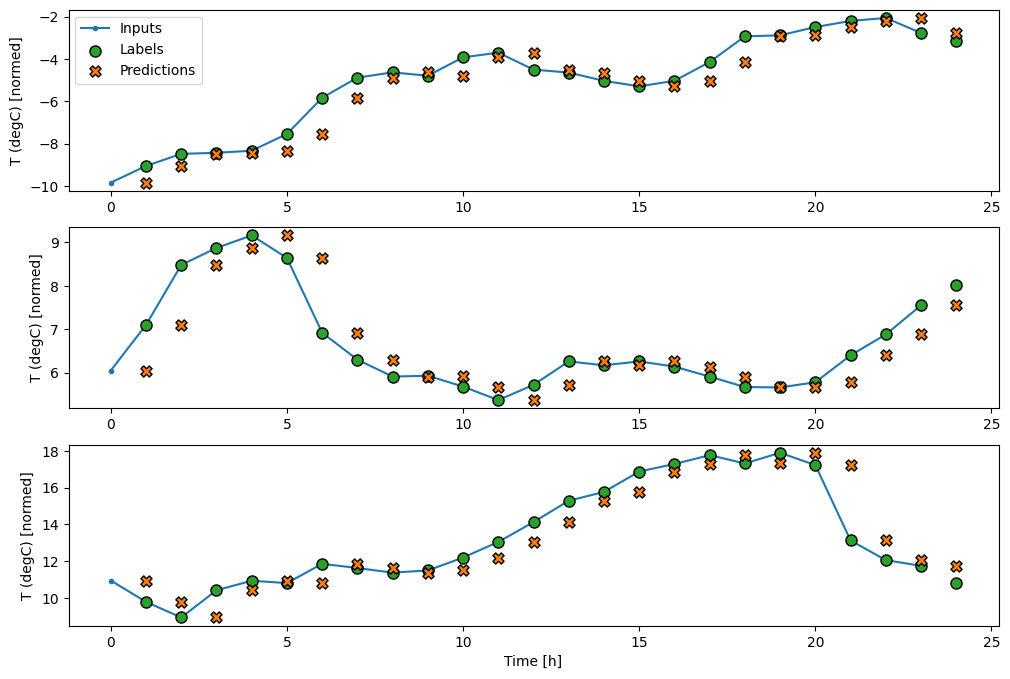

In [ ]:
wide_window.plot(baseline)

In [ ]:
print(f' MAE: {wide_window.mae(baseline)}')

 MAE: 0.6729556918144226


## Training function

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


## Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 [==============================] - 11s 6ms/step - loss: 1650.0349 - mean_absolute_error: 15.2047 - val_loss: 12.0846 - val_mean_absolute_error: 2.7998
Epoch 2/20
1534/1534 [==============================] - 9s 6ms/step - loss: 6.0303 - mean_absolute_error: 1.8801 - val_loss: 3.4858 - val_mean_absolute_error: 1.4559
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 3.2632 - mean_absolute_error: 1.3947 - val_loss: 2.9795 - val_mean_absolute_error: 1.3306
Epoch 4/20
1534/1534 [==============================] - 10s 6ms/step - loss: 2.9159 - mean_absolute_error: 1.3167 - val_loss: 2.7780 - val_mean_absolute_error: 1.2891
Epoch 5/20
1534/1534 [==============================] - 9s 6ms/step - loss: 2.6360 - mean_absolute_error: 1.2552 - val_loss: 2.9118 - val_mean_absolute_error: 1.3446
Epoch 6/20
1534/1534 [==============================] - 9s 6ms/step - loss: 2.4174 - mean_absolute_error: 1.2054 

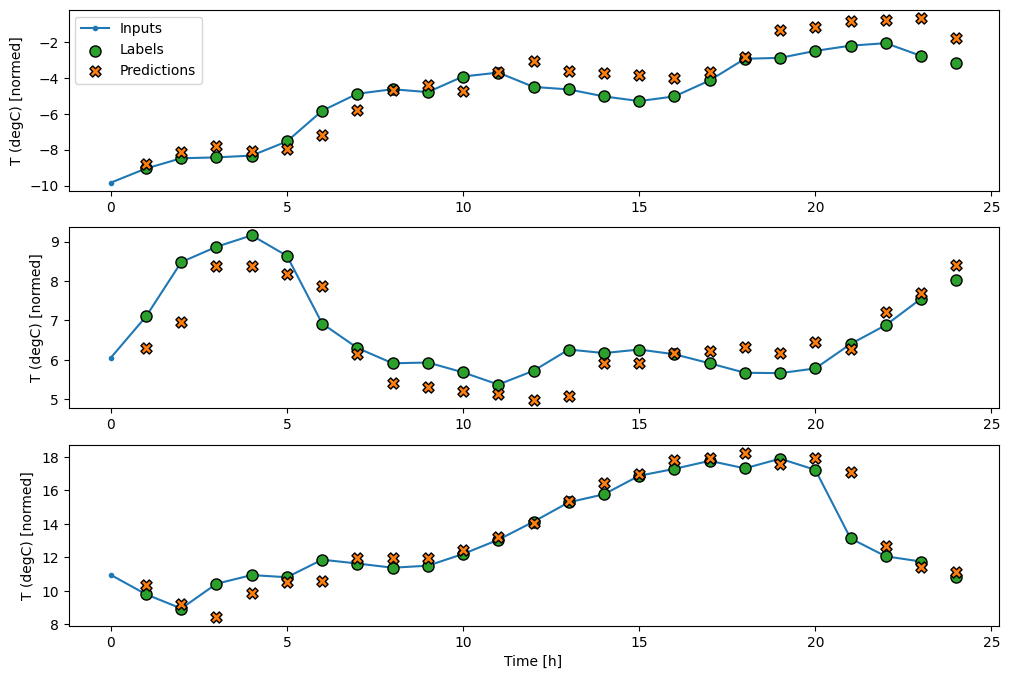

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

In [ ]:
print(f' MAE: {wide_window.mae(linear)}\n')

 MAE: 0.6734904646873474



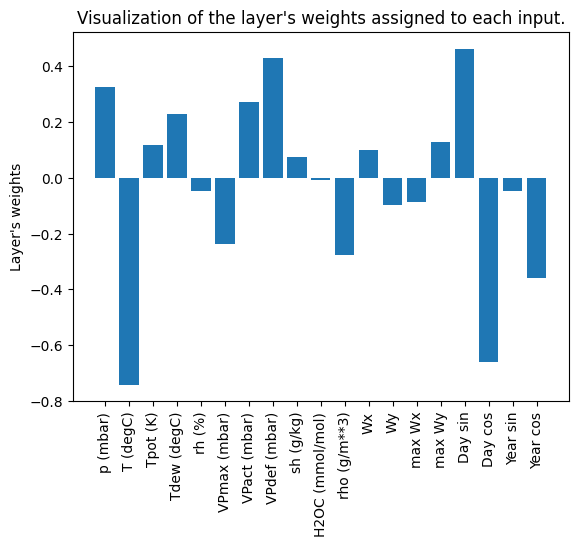

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
plt.title("Visualization of the layer's weights assigned to each input.")
plt.ylabel("Layer's weights")
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output:

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)
Epoch 1/20
1534/1534 [==============================] - 15s 9ms/step - loss: 3.3870 - mean_absolute_error: 1.1360 - val_loss: 0.7746 - val_mean_absolute_error: 0.6465
Epoch 2/20
1534/1534 [==============================] - 12s 8ms/step - loss: 1.9290 - mean_absolute_error: 1.0932 - val_loss: 1.5101 - val_mean_absolute_error: 1.0102
Epoch 3/20
439/439 [==============================] - 2s 4ms/step - loss: 1.9627 - mean_absolute_error: 1.2067
 MAE: 1.1669166088104248


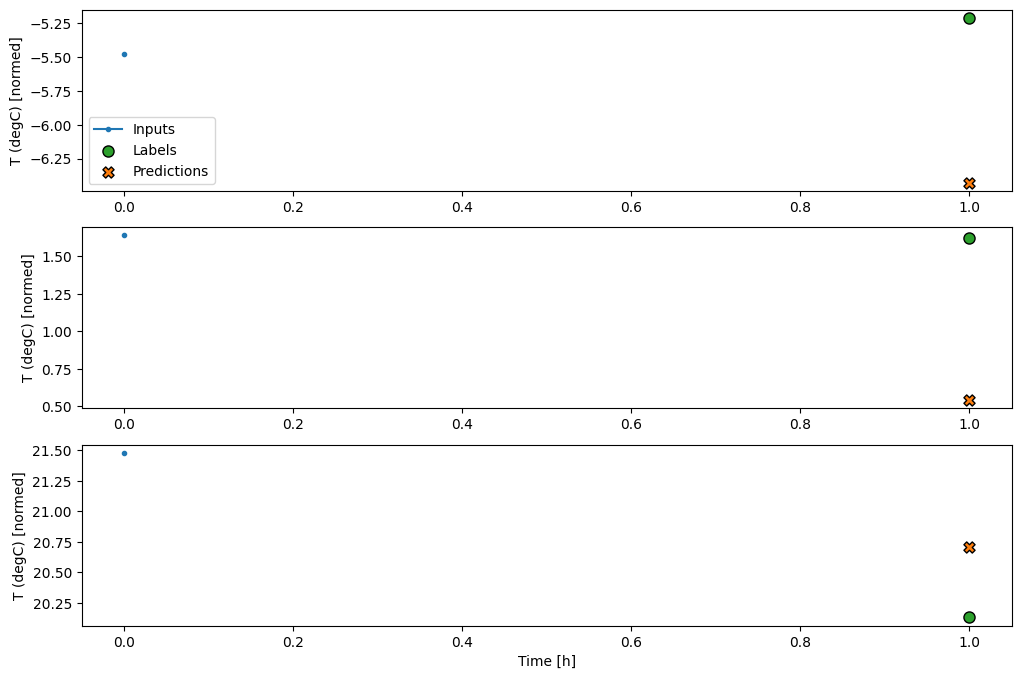

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', dense(single_step_window.example[0]).shape)

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

print(f' MAE: {single_step_window.mae(dense)}')

single_step_window.plot(dense)

## Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)

The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 3
Shift: 1
Total window size: 4

<ipython-input-56-ddf8d4574db5>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(max_n, 1, n + 1)


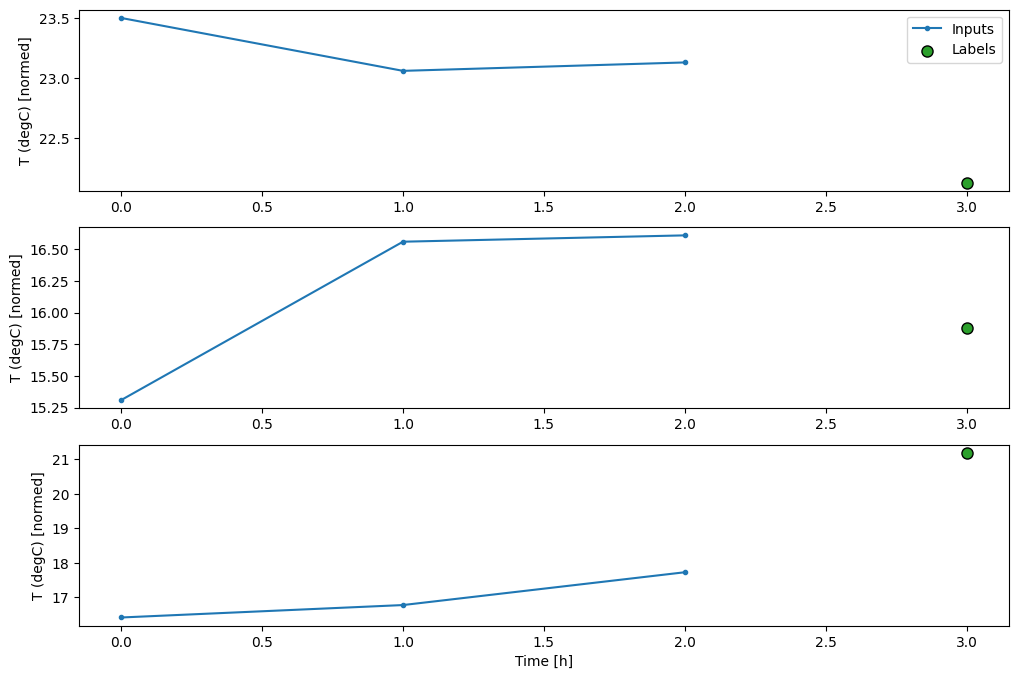

In [ ]:
conv_window.plot(title="Given 3 hours of inputs, predict 1 hour into the future.")

439/439 [==============================] - 1s 3ms/step - loss: 3.2385 - mean_absolute_error: 1.6457
MAE: 1.7633256912231445


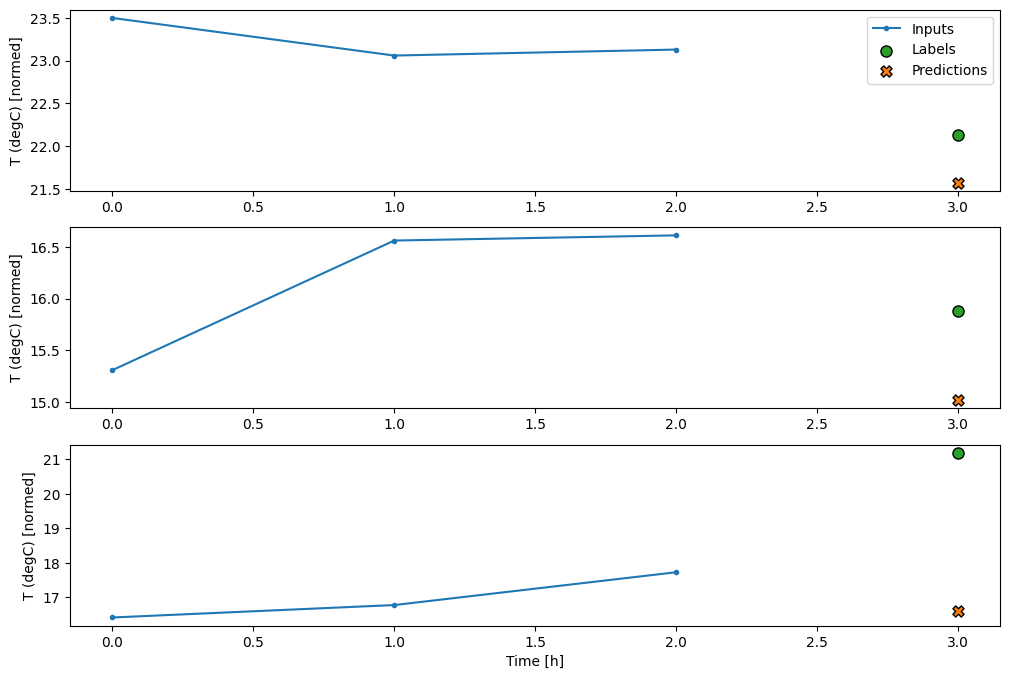

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

print(f'MAE: {conv_window.mae(multi_step_dense)}')

conv_window.plot(multi_step_dense)

## Convolution neural network

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution.

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

439/439 [==============================] - 3s 6ms/step - loss: 0.7292 - mean_absolute_error: 0.6244
Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']
Label columns indices: {'T (degC)': 0}
Window size: 26
Shift: 1
Total window size: 27

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)

MAE: 0.5811499953269958


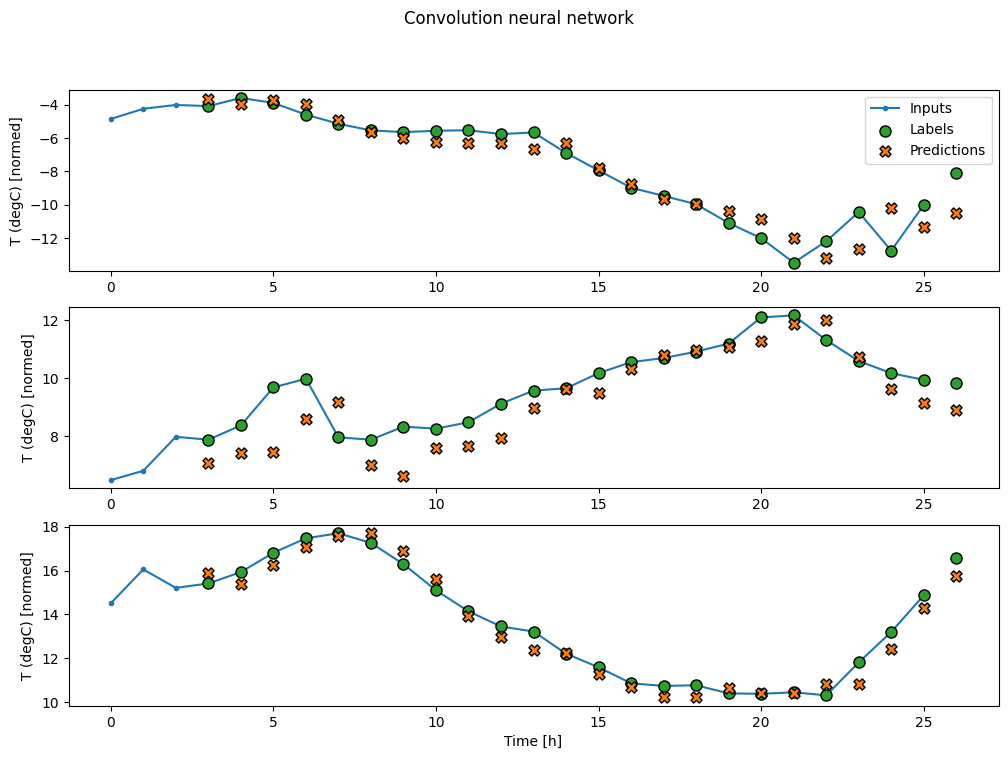

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
print('')
print(f'MAE: {wide_conv_window.mae(conv_model)}')

wide_conv_window.plot(conv_model, title="Convolution neural network")


## Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


438/438 [==============================] - 2s 5ms/step - loss: 1.3444 - mean_absolute_error: 0.7156

MAE: 0.6162687540054321


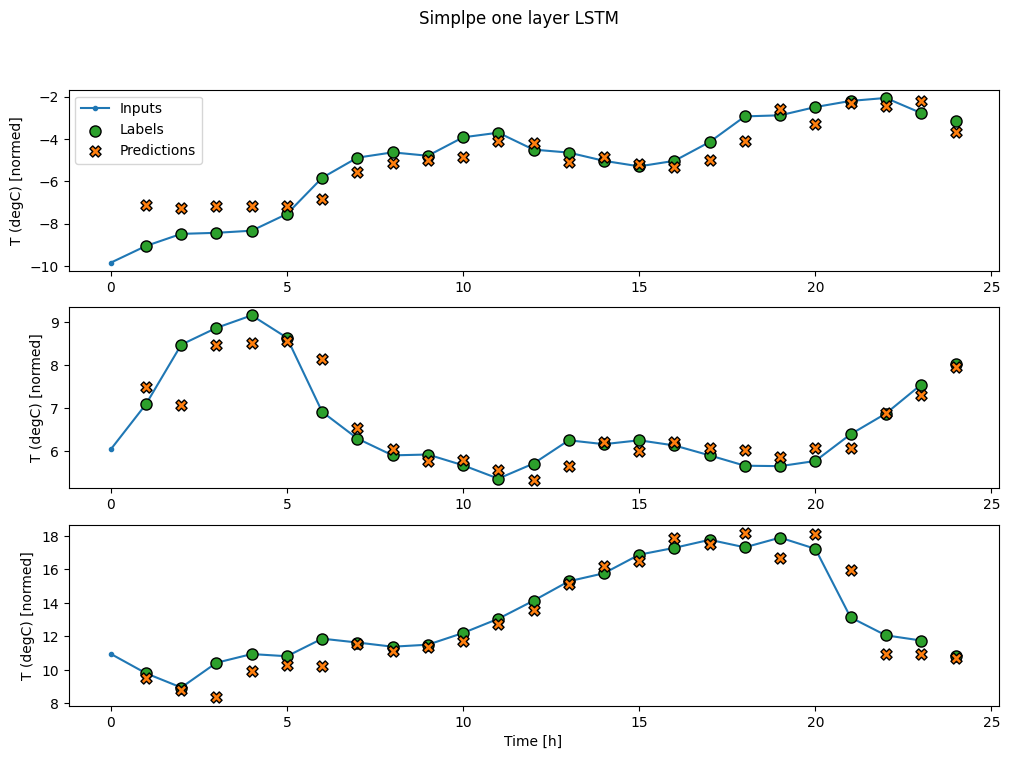

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

print('')
print(f'MAE: {wide_window.mae(lstm_model)}')

wide_window.plot(lstm_model, title='Simplpe one layer LSTM')

## Performance

Baseline    : 0.7361
Linear      : 0.6238
Dense       : 1.1648
Multi step dense: 1.6340
Conv        : 0.5973
LSTM        : 0.7279


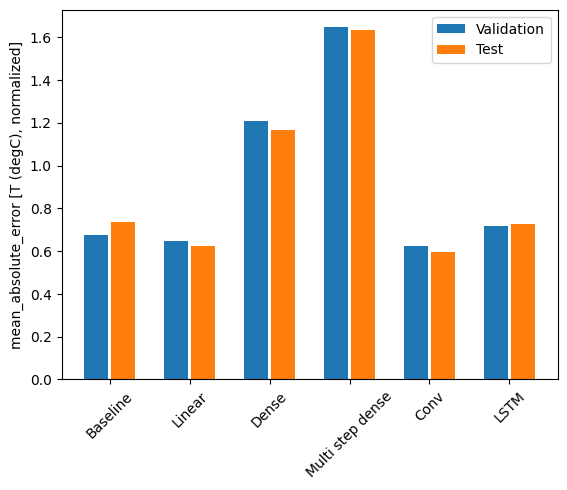

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Single step models. Multi-output features.

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


## Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 3ms/step - loss: 2.7484 - mean_absolute_error: 0.7470


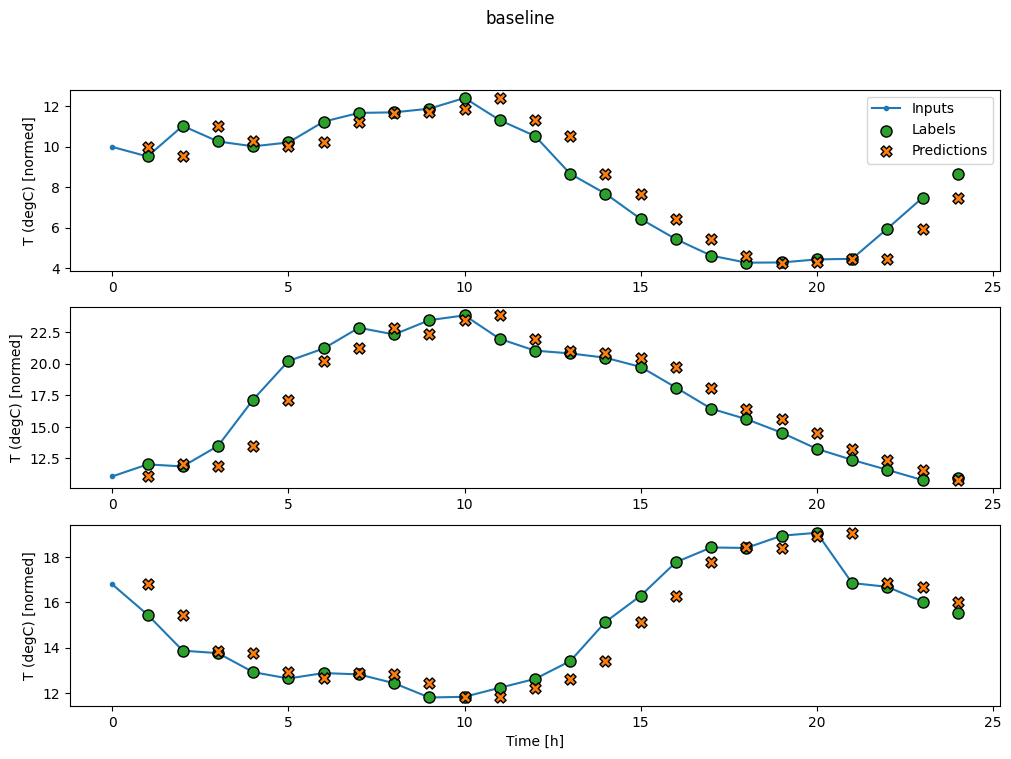

In [ ]:
wide_window.plot(baseline, title='baseline')

## Dense

439/439 [==============================] - 2s 5ms/step - loss: 3.6241 - mean_absolute_error: 1.1212


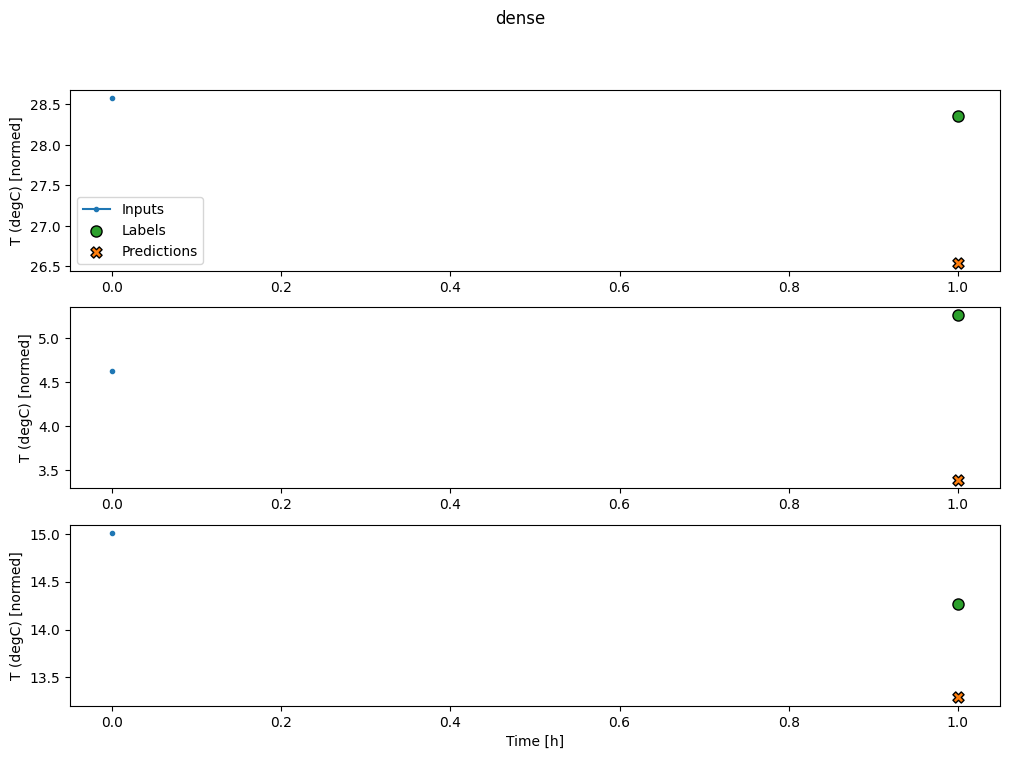

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

single_step_window.plot(dense, title='dense')

## RNN

438/438 [==============================] - 2s 5ms/step - loss: 73047.9375 - mean_absolute_error: 90.7497

CPU times: user 5min 44s, sys: 37.1 s, total: 6min 21s
Wall time: 5min 45s


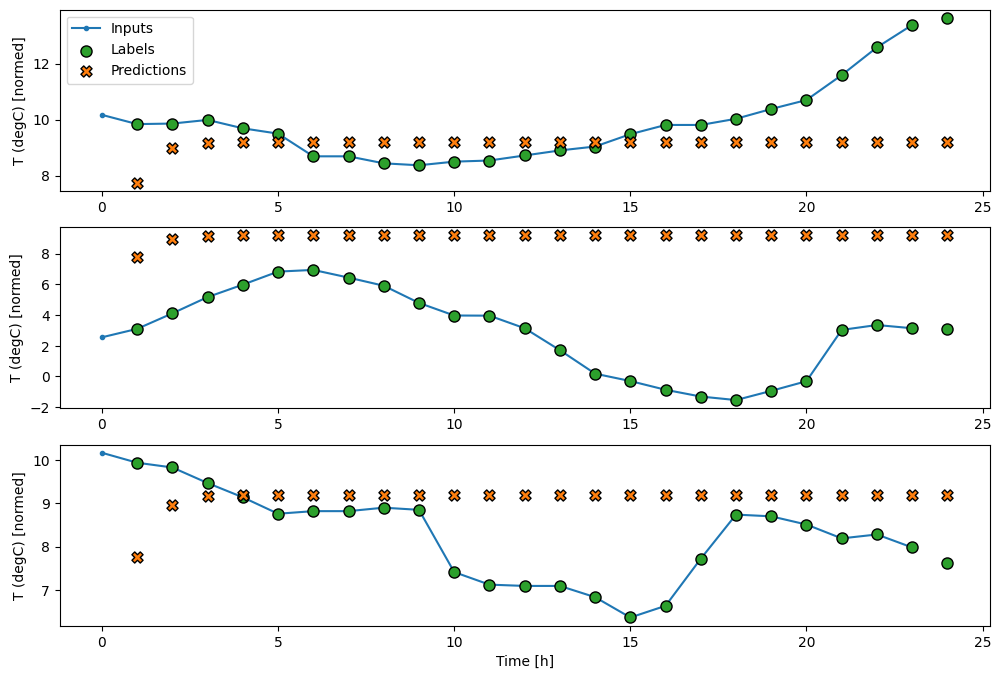

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

print()
wide_window.plot(lstm_model)

## Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial.

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

438/438 [==============================] - 3s 6ms/step - loss: 2.0394 - mean_absolute_error: 0.6809

CPU times: user 2min 22s, sys: 15.2 s, total: 2min 37s
Wall time: 2min 24s


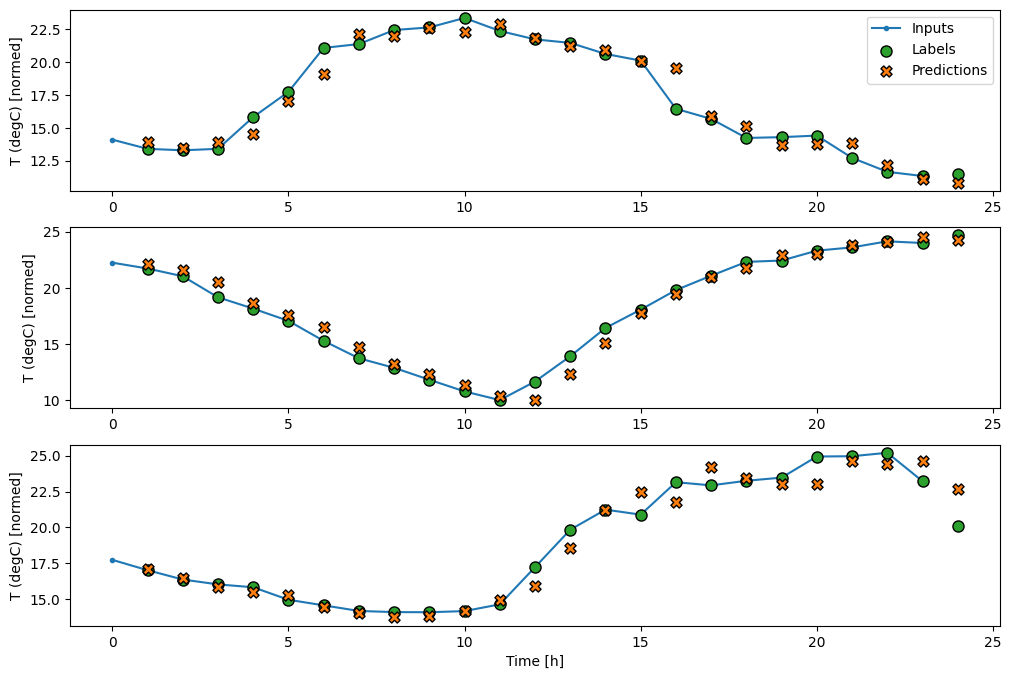

In [ ]:
%%time

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()
wide_window.plot(residual_lstm)

## Performance

Baseline       : 0.7919
Dense          : 1.1108
LSTM           : 92.6857
Residual LSTM  : 0.6874


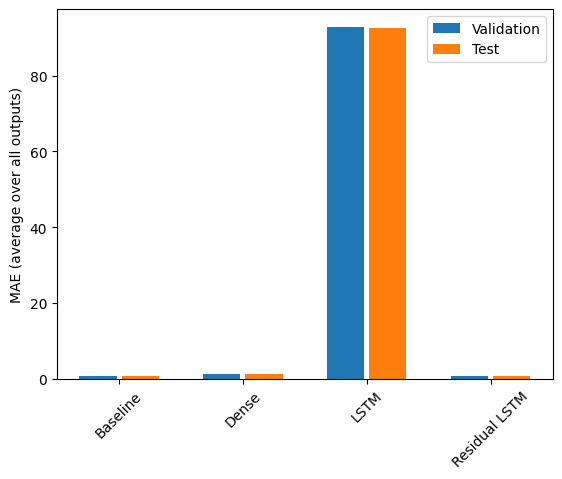

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

AttributeError: ignored

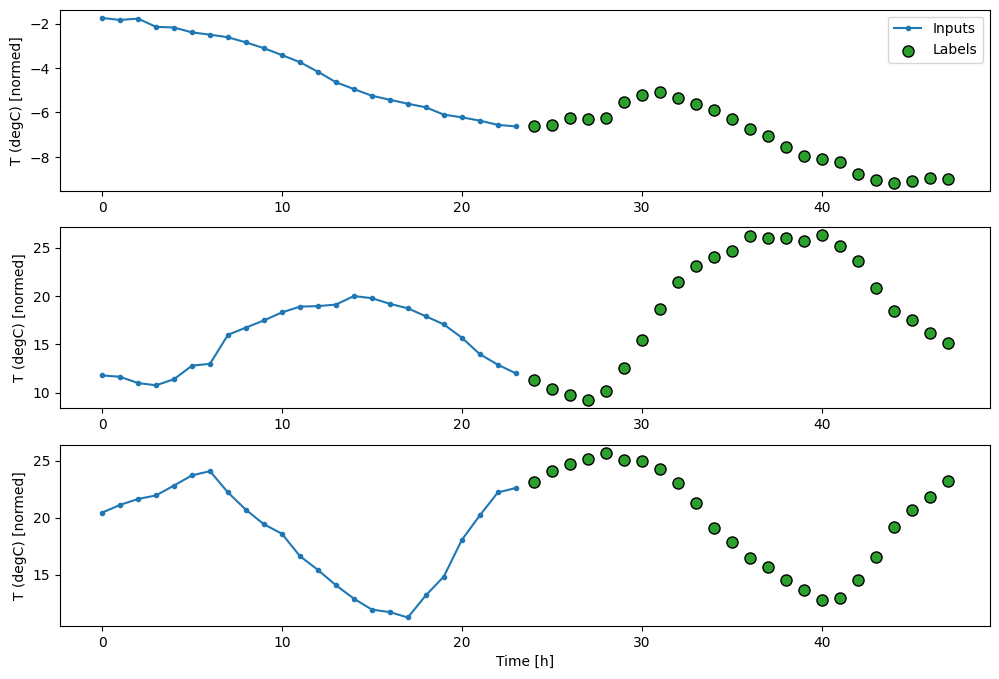

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

437/437 [==============================] - 2s 4ms/step - loss: 43.7830 - mean_absolute_error: 2.9353


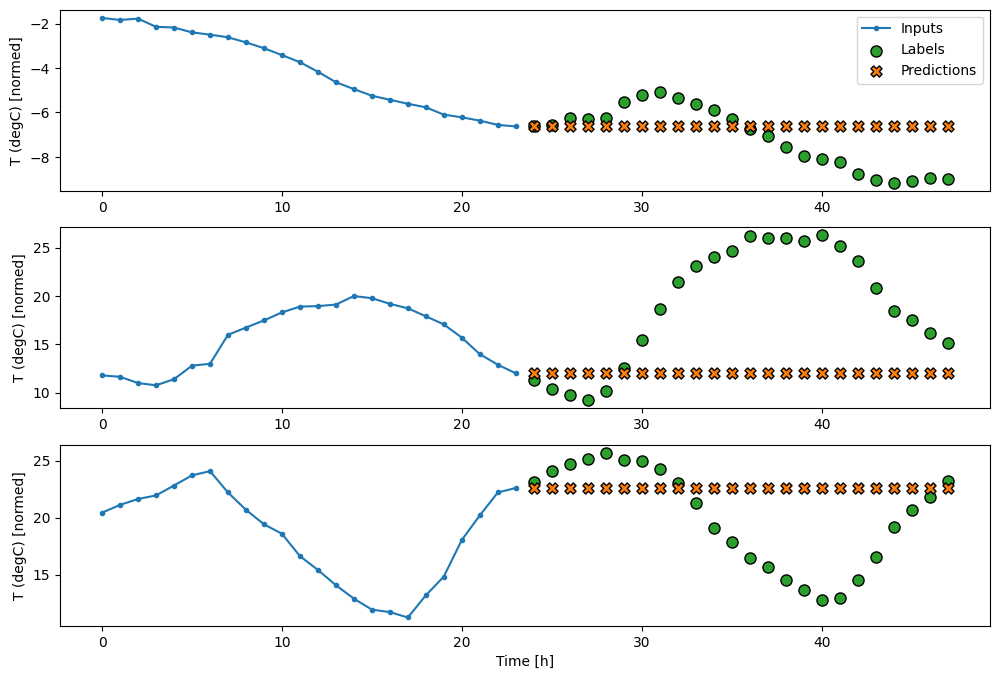

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

437/437 [==============================] - 2s 5ms/step - loss: 35.2800 - mean_absolute_error: 2.7802


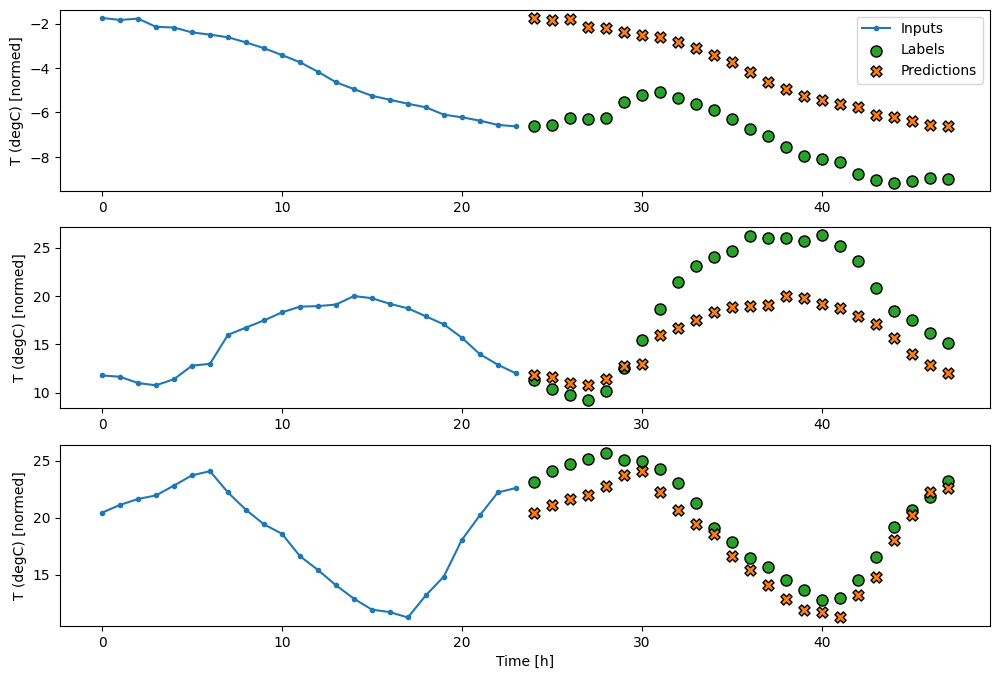

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

437/437 [==============================] - 2s 5ms/step - loss: 22.1827 - mean_absolute_error: 2.2443


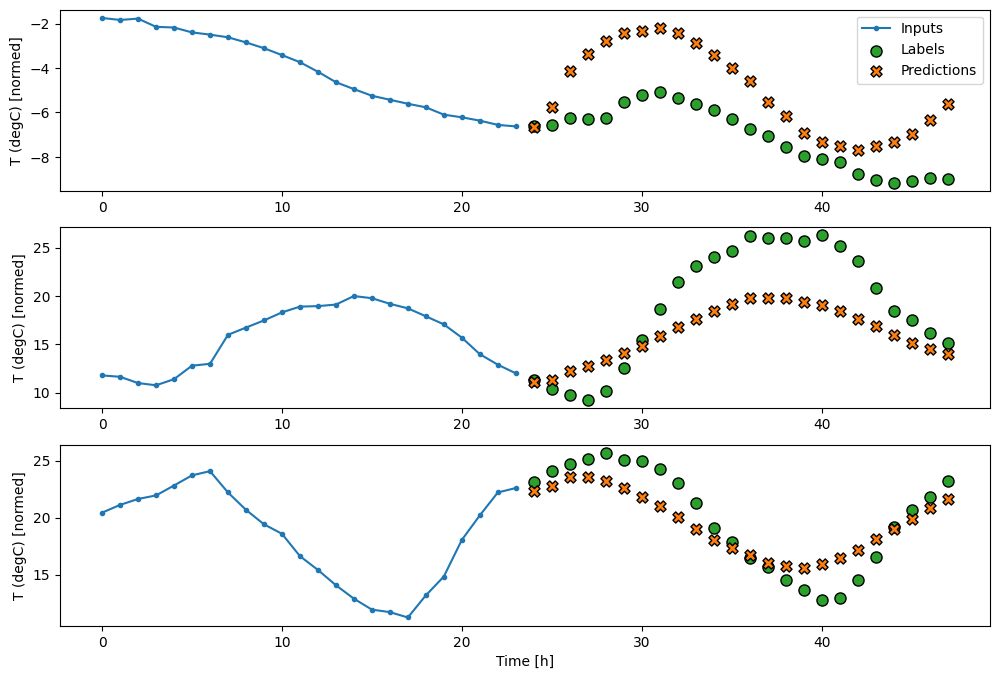

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

437/437 [==============================] - 3s 5ms/step - loss: 29.1787 - mean_absolute_error: 2.7525


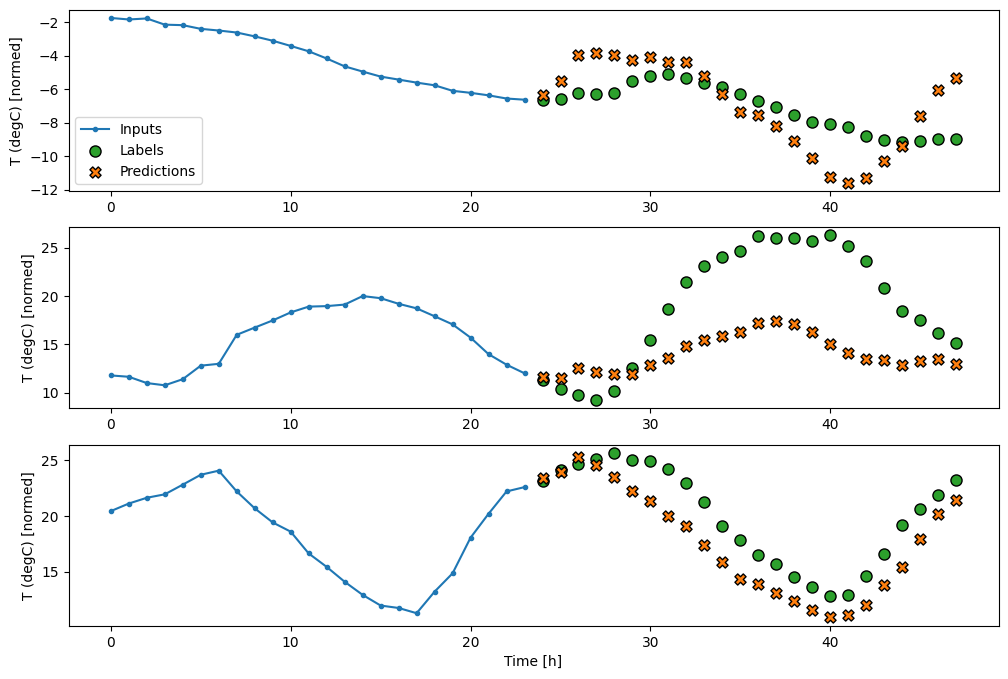

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

437/437 [==============================] - 2s 5ms/step - loss: 27.4078 - mean_absolute_error: 3.0404


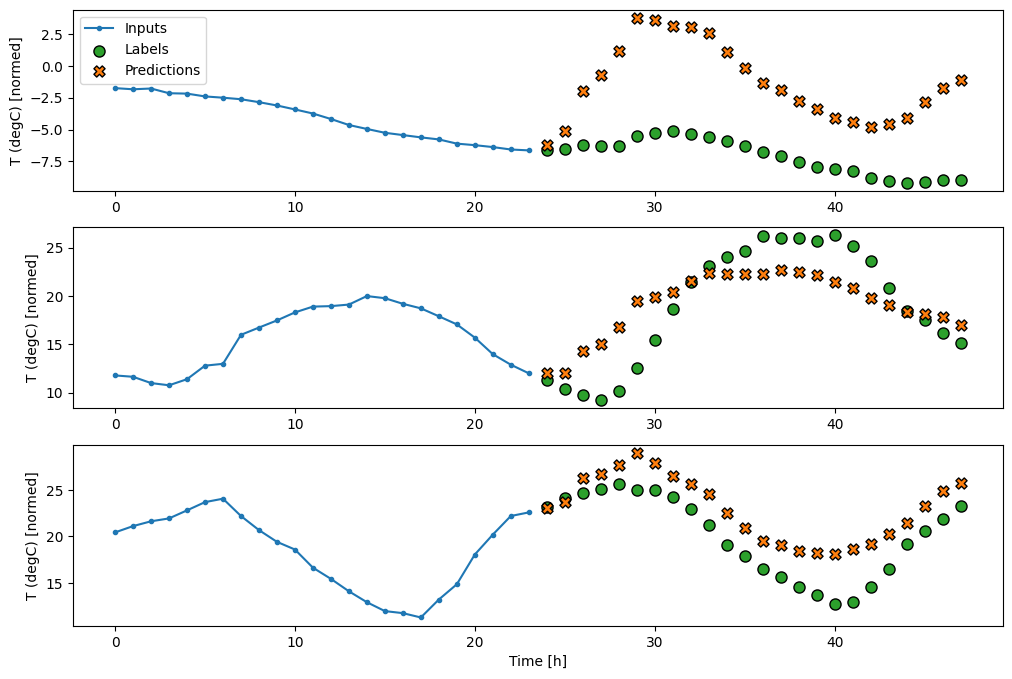

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


437/437 [==============================] - 2s 4ms/step - loss: 64818.8438 - mean_absolute_error: 84.7159


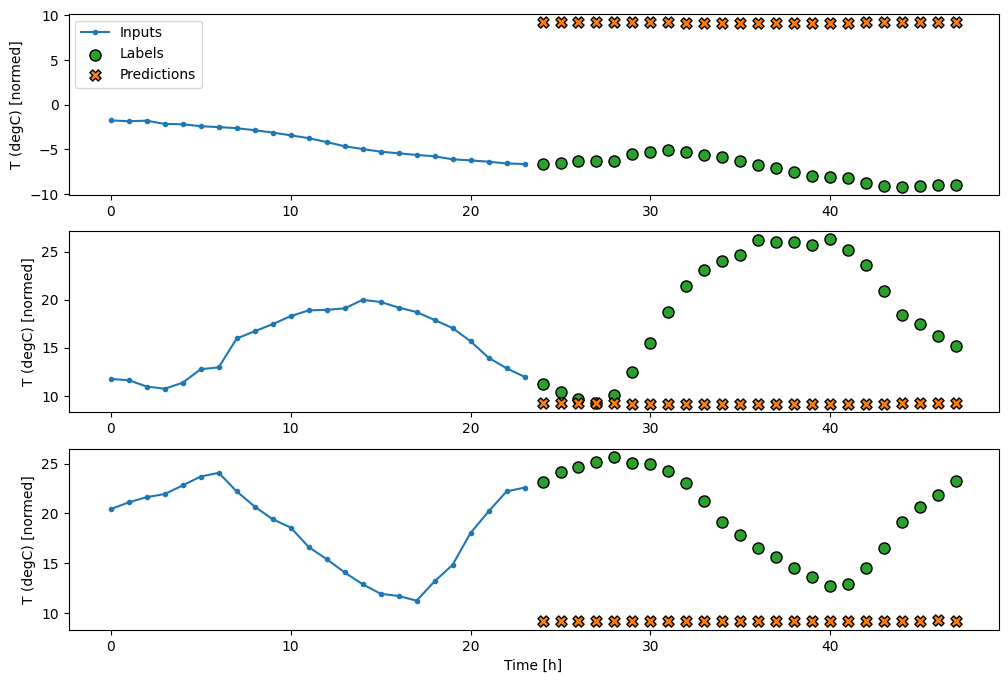

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a warmup method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step LSTM model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the RNN's state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a tf.stack after the loop.

Note: Stacking a Python list like this only works with eager-execution, using Model.compile(..., run_eagerly=True) for training, or with a fixed length output. For a dynamic output length, you would need to use a tf.TensorArray instead of a Python list, and tf.range instead of the Python range.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 5s 11ms/step - loss: 3503.8892 - mean_absolute_error: 19.1429


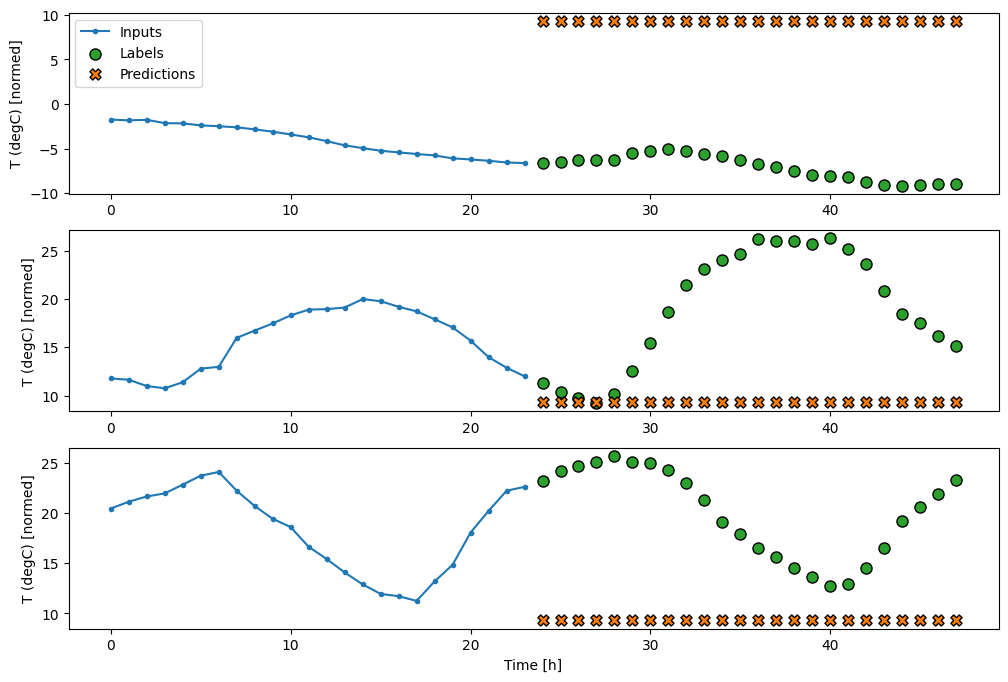

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance

There are clearly diminishing returns as a function of model complexity on this problem:

Last    : 3.0998
Repeat  : 2.5897
Linear  : 2.1667
Dense   : 2.6681
Conv    : 2.9746
LSTM    : 84.3461
AR LSTM : 18.7582


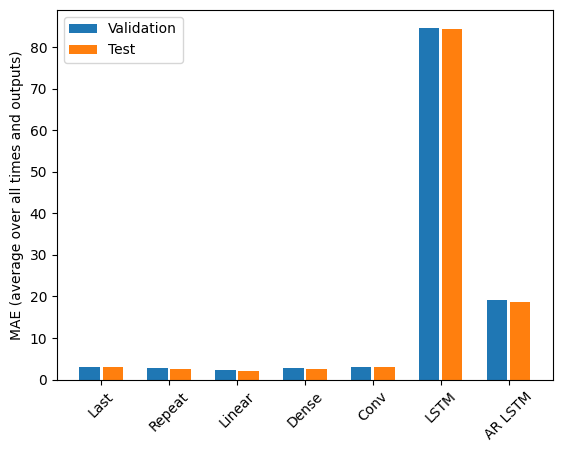

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

As we can see LSTM - Predicting the same constant values.
The root causes could be:
* Second reproducing touches the first part of the tutorial (dataset clearing and preparing)
* Needs to add Mixture Density Layers: Christopher Bishop's in [paper on MDN layers](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) shows that basically the L2 loss tries to predict the conditional average of some input's error terms as y. If for one value x you have multiple possible outputs y0, y1, y2, each with some probability (as many complex systems will), you'll want to consider the MDN layer and a negative log likelihood loss.
* Feeding the LSTM longer sequences. it helpful to feed my LSTM n sequence values prior to the one I'm trying to predict. The larger n is, the better the results I've found (though slower the training goes) e.g. 1024.